In [1]:
# EEG band filtering

In [2]:
from numpy.fft import fft, ifft, fftfreq
import bioread
import matplotlib.pyplot as plt
import numpy as np

In [3]:
## Frequency Domain filtering

In [4]:
### Mock Data

In [5]:
#  Filter a sinewave using the low-pass filter
SAMPLING_FREQUENCY = 64000
NUMBER_OF_SAMPLES = 128
TIME_ARRAY = np.arange(NUMBER_OF_SAMPLES)
FIRST_FREQUENCY = 3000
SECOND_FREQUENCY = 15000
BAND_LENGTH = 200

first_sine = np.sin(2* np.pi * FIRST_FREQUENCY/SAMPLING_FREQUENCY * TIME_ARRAY) 
second_sine = np.sin(2* np.pi * SECOND_FREQUENCY/SAMPLING_FREQUENCY * TIME_ARRAY)
combined_sine = first_sine + second_sine

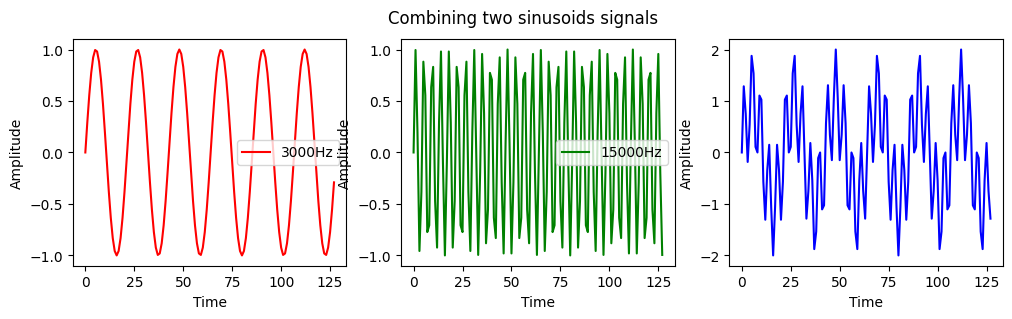

In [6]:
fig=plt.figure(figsize=(12,3), dpi= 100, facecolor='w', edgecolor='k')
fig.suptitle('Combining two sinusoids signals');

plt.subplot(1,3,1);
plt.plot(TIME_ARRAY, first_sine, color = 'r', label=str(FIRST_FREQUENCY) + 'Hz'); 
plt.xlabel('Time');
plt.ylabel('Amplitude');
plt.legend()

plt.subplot(1,3,2);
plt.plot(TIME_ARRAY, second_sine, color = 'g', label=str(SECOND_FREQUENCY) + 'Hz');
plt.xlabel('Time');
plt.ylabel('Amplitude');
plt.legend()

plt.subplot(1,3,3);
plt.plot(TIME_ARRAY, combined_sine, color = 'b');
plt.xlabel('Time');
plt.ylabel('Amplitude');

In [7]:
def plot_spectrum(spectrum, number_of_samples, sampling_frequency, title):
    frequencies = fftfreq(number_of_samples, 1 / sampling_frequency)
    
    # hold only the positive absolute of the spectrum
    spectrum = abs(spectrum[0: int(number_of_samples / 2)])
    spectrum_x = frequencies[0: int(number_of_samples / 2)]
    
    fig=plt.figure(figsize=(12,3), dpi= 100, facecolor='w', edgecolor='k')
    fig.suptitle(title);
    plt.xlabel('Frequency');
    plt.ylabel('Power');
        
    
    plt.stem(spectrum_x, spectrum)

In [8]:
def spectrum_domain_band_pass_filter(low_cut_off, high_cut_off, number_of_samples, sampling_frequency, spectrum):
    spectrum_frequencies = fftfreq(number_of_samples, 1 / sampling_frequency)

    # cutting the lower frequencies
    filtered_spectrum = spectrum * (np.absolute(spectrum_frequencies) > low_cut_off) 
    
    # cutting the higher frequencies
    filtered_spectrum = filtered_spectrum * (np.absolute(spectrum_frequencies) < high_cut_off)
    
    return filtered_spectrum

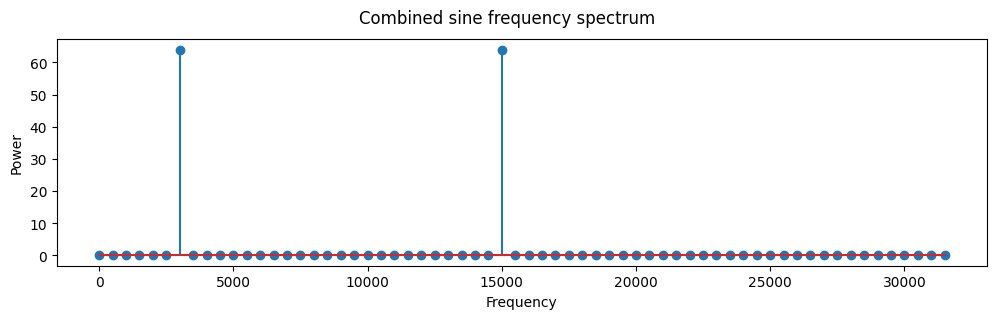

In [9]:
# COMBINED SPECTRUM
combined_sine_spectrum = fft(combined_sine)
plot_spectrum(combined_sine_spectrum, NUMBER_OF_SAMPLES, SAMPLING_FREQUENCY, 'Combined sine frequency spectrum')

In [10]:
# FIRST SINE SPECTRUM
low = abs(FIRST_FREQUENCY - BAND_LENGTH)
high = abs(FIRST_FREQUENCY + BAND_LENGTH)
first_sine_spectrum = spectrum_domain_band_pass_filter(
    low, high, NUMBER_OF_SAMPLES, SAMPLING_FREQUENCY, combined_sine_spectrum)

# SECOND SINE SPECTRUM
low = abs(SECOND_FREQUENCY - BAND_LENGTH)
high = abs(SECOND_FREQUENCY + BAND_LENGTH)
second_sine_spectrum = spectrum_domain_band_pass_filter(
    low, high, NUMBER_OF_SAMPLES, SAMPLING_FREQUENCY, combined_sine_spectrum)

# BACK TO TIME
first_sine_recomposed = np.real(ifft(first_sine_spectrum))
second_sine_recomposed = np.real(ifft(second_sine_spectrum))

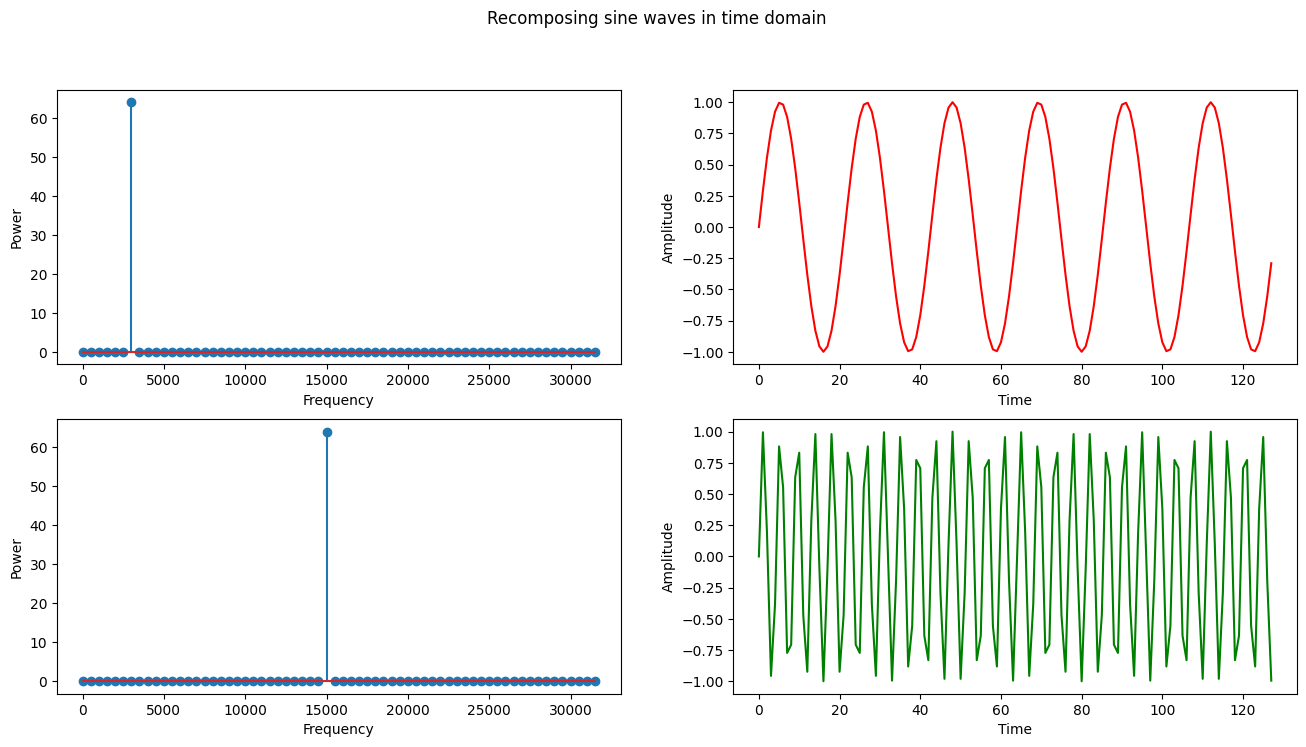

In [11]:
frequencies = fftfreq(NUMBER_OF_SAMPLES, 1 / SAMPLING_FREQUENCY)
spectrum_x = frequencies[0: int(NUMBER_OF_SAMPLES / 2)]


fig=plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
# fig=plt.figure()
fig.suptitle('Recomposing sine waves in time domain');

plt.subplot(2,2,1);
first_sine_spectrum = abs(first_sine_spectrum[0: int(NUMBER_OF_SAMPLES / 2)])
plt.stem(spectrum_x, first_sine_spectrum)
plt.xlabel('Frequency');
plt.ylabel('Power');

plt.subplot(2,2,2);
plt.plot(TIME_ARRAY, first_sine_recomposed, color = 'r', label=str(FIRST_FREQUENCY) + 'Hz'); 
plt.xlabel('Time');
plt.ylabel('Amplitude');

plt.subplot(2,2,3);
second_sine_spectrum = abs(second_sine_spectrum[0: int(NUMBER_OF_SAMPLES / 2)])
plt.stem(spectrum_x, second_sine_spectrum)
plt.xlabel('Frequency');
plt.ylabel('Power');

plt.subplot(2,2,4);
plt.plot(TIME_ARRAY, second_sine_recomposed, color = 'g', label=str(SECOND_FREQUENCY) + 'Hz');
plt.xlabel('Time');
plt.ylabel('Amplitude');

In [12]:
### Real Data

In [13]:
file_data = bioread.read_file('data/input_data.acq')
print("file_data", file_data)


# We will use only the data acquisitioned from one channel (e.g. Channel ECoG F)
channel = file_data.channels[3]
print("channel", channel)


file_data AcqKnowledge file (rev 108): 4 channels, 1000.0 samples/sec
channel Channel ECoG F: 179989 samples, 1000.0 samples/sec, loaded: True


In [14]:
def plot_channel(channel):
    fig=plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
    fig.suptitle(channel.name);

    plt.plot(channel.time_index, channel.data)
    plt.xlabel("Time (s)");
    plt.ylabel("Amplitude (" + channel.units + ")");

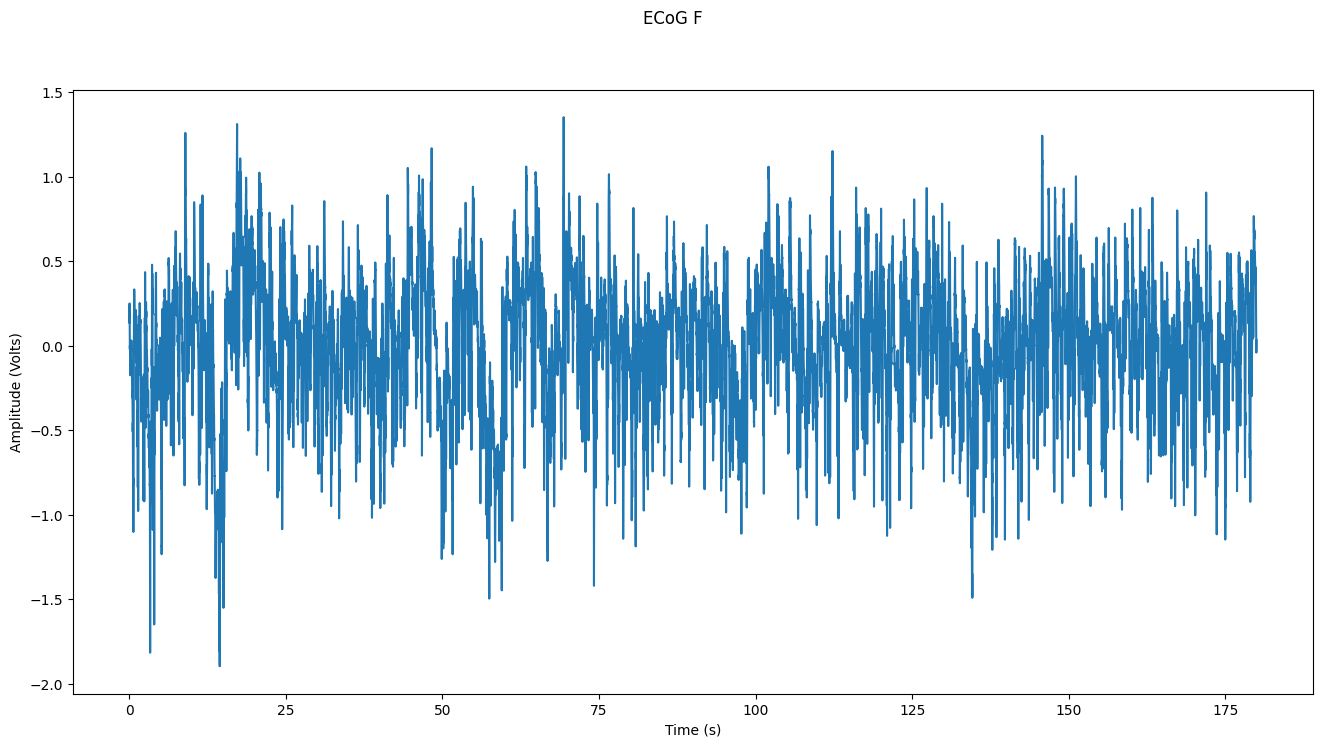

In [15]:
plot_channel(channel)

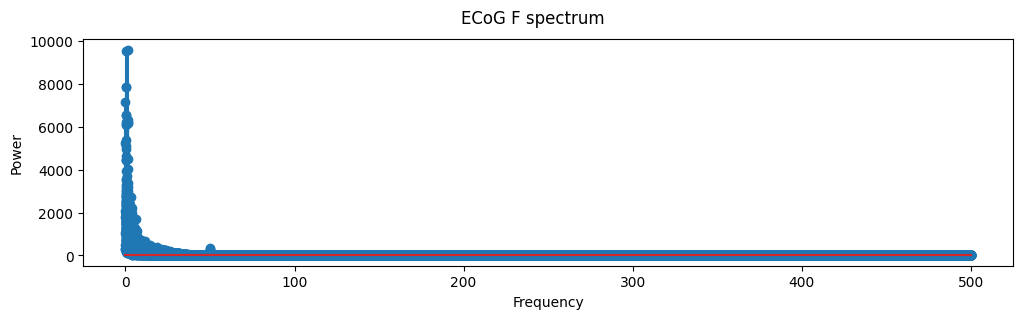

In [16]:
plot_spectrum(fft(channel.data), len(channel.data), channel.samples_per_second, channel.name + " spectrum")

In [17]:
band_waves_definitions = {'delta': {'name' : 'Delta wave', 'low' : 1, 'high' : 4, 'color' : 'b'},
                        'theta': {'name' : 'Theta wave', 'low' : 4, 'high' : 8, 'color' : 'g'},
                        'alpha': {'name' : 'Alpha wave', 'low' : 8, 'high' : 12, 'color' : 'r'},
                        'beta': {'name' : 'Beta wave', 'low' : 13, 'high' : 30, 'color' : 'c'},
                        'low_gamma': {'name' : 'Low Gamma wave', 'low' : 30, 'high' : 70, 'color' : 'm'},
                        'high_gamma': {'name' : 'High Gamma wave', 'low' : 70, 'high' : 150, 'color' : 'y'}}

In [18]:
def find_brain_wave(brain_wave_definition, channel):
    low_cutoff = brain_wave_definition['low']
    high_cutoff = brain_wave_definition['high']
    number_of_samples = len(channel.data)
    sampling_frequency = channel.samples_per_second
    time_index = channel.time_index
    measuring_units = channel.units
    
    # compute spectrum of the initial signal
    channel_spectrum = fft(channel.data)
    
    # filter out only the wanted brain wave
    brain_wave_spectrum = spectrum_domain_band_pass_filter(
        low_cutoff, high_cutoff, number_of_samples, sampling_frequency, channel_spectrum)
    
    # compute the brain wave in time domain
    computed_brain_wave = np.real(ifft(brain_wave_spectrum))
    
    # prepare spectrum for plot
    frequencies = fftfreq(number_of_samples, 1 / sampling_frequency)
    spectrum_x = frequencies[0: int(number_of_samples / 2)]
    brain_wave_spectrum = abs(brain_wave_spectrum[0: int(number_of_samples / 2)])
    
    
    # Plot...
    fig=plt.figure(figsize=(16,4), dpi=100, facecolor='w', edgecolor='k')
    fig.suptitle(brain_wave_definition['name']);
    
    # Plot the spectrum
    plt.subplot(1,2,1);
    plt.stem(spectrum_x, brain_wave_spectrum)
    plt.xlabel('Frequency');
    plt.ylabel('Power');
    
    # Plot the brain wave
    plt.subplot(1,2,2);
    plt.plot(time_index, computed_brain_wave,
             color = brain_wave_definition['color'],
             label="({}, {}) Hz".format(low_cutoff, high_cutoff)); 
    plt.xlabel("Time(s)")
    plt.ylabel('Amplitude(' + measuring_units + ")");

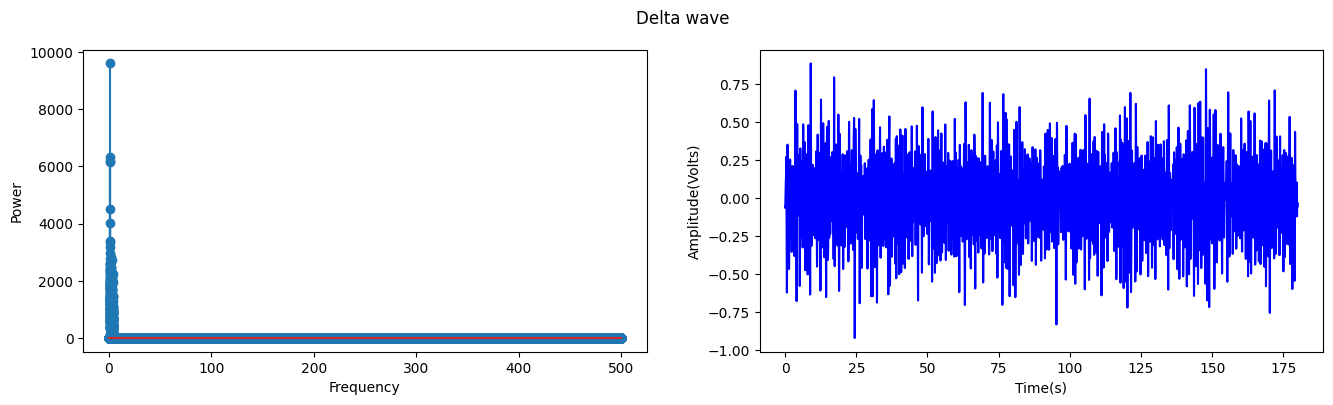

In [19]:
find_brain_wave(band_waves_definitions['delta'], channel)

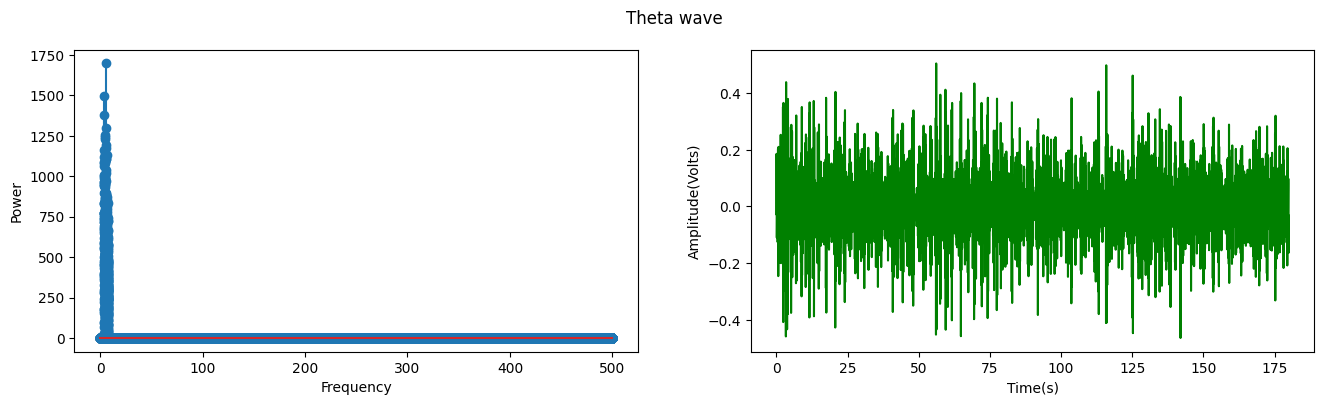

In [20]:
find_brain_wave(band_waves_definitions['theta'], channel)

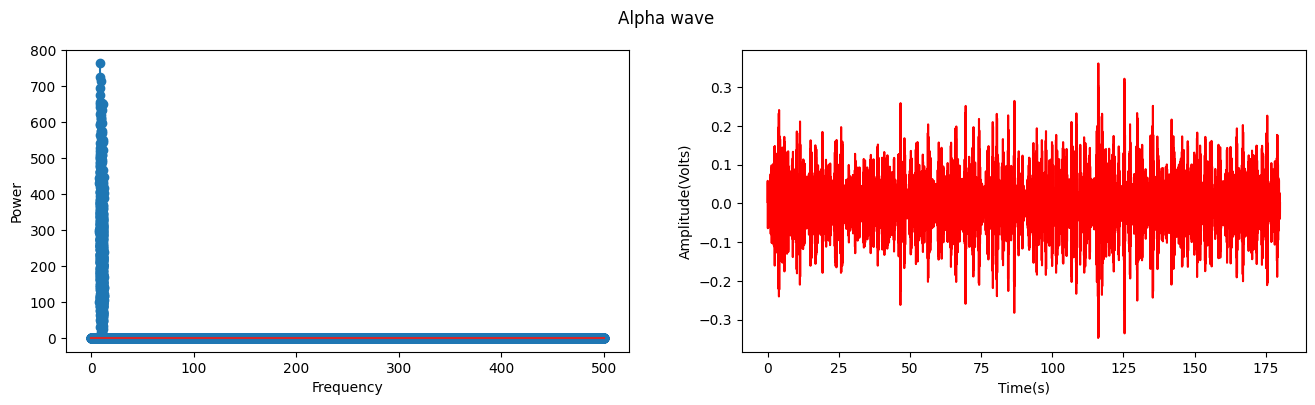

In [21]:
find_brain_wave(band_waves_definitions['alpha'], channel)

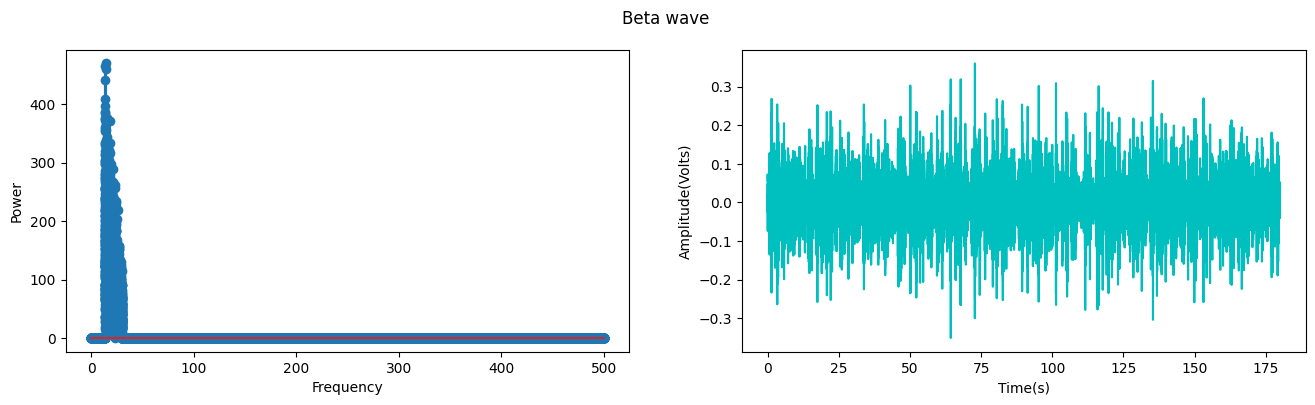

In [22]:
find_brain_wave(band_waves_definitions['beta'], channel)

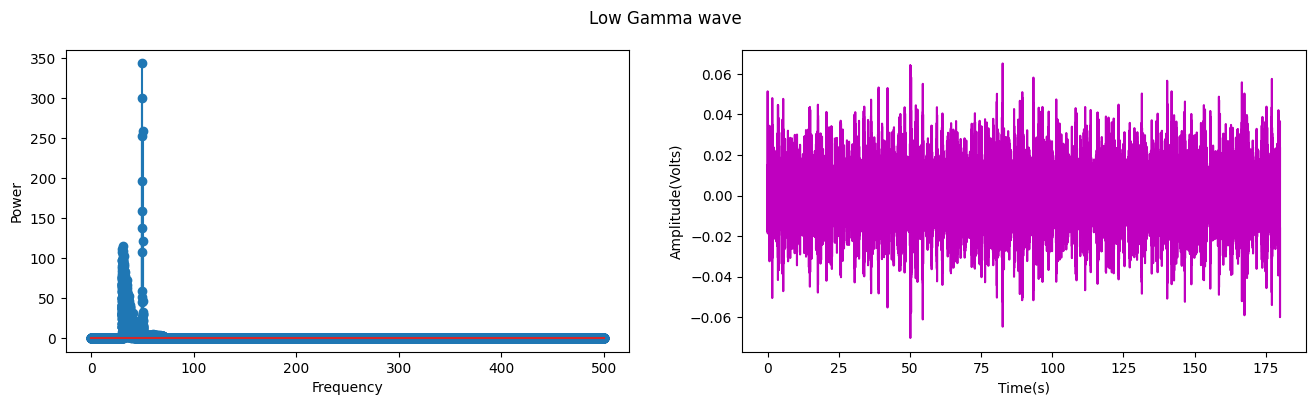

In [23]:
find_brain_wave(band_waves_definitions['low_gamma'], channel)

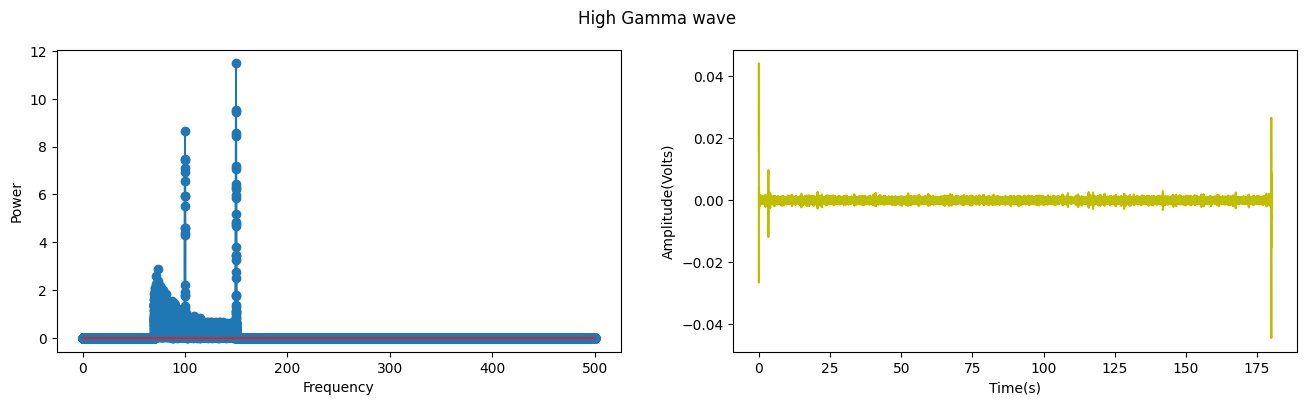

In [24]:
find_brain_wave(band_waves_definitions['high_gamma'], channel)